In [56]:
import torch
import torch_geometric
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data, DataLoader
from scipy.stats import ortho_group, special_ortho_group
from collections import Counter

# pop out plots
%matplotlib qt

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [90]:
def plot(G, pos, node_colors, edge_colors=None, cmap=plt.cm.coolwarm, with_labels=False):
    
    vmin = np.min(node_colors)
    vmax = np.max(node_colors)
    vfinal = np.max(np.abs([vmin, vmax]))
    
    options = {'node_color': node_colors, 'node_size': 150, 'cmap': cmap,
               'vmin': -vfinal, 'vmax': vfinal}
    
    if edge_colors is not None:
        options['edge_color'] = edge_colors
        options['edge_cmap'] = cmap
        options['edge_vmin'] = np.min(edge_colors)
        options['edge_vmax'] = np.max(edge_colors)
        options['width'] = 8

    nx.draw(G, pos=pos, with_labels=with_labels, **options)
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-vfinal, vmax=vfinal), cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=plt.gca())

def normalize(x):
    """
    Normalizes a signal x to the range [-1, 1]
    :param x: signal
    :return: normalized signal
    """
    return (x - x.min()) / (x.max() - x.min()) * 2 - 1

def construct_block_diagonal_ortho(eigenvalues, round_precision=3):
    eigenvalues_round = np.round(eigenvalues, round_precision)
    cntr = Counter(eigenvalues_round)
    
    n = len(eigenvalues)
    R = np.zeros((n, n))
    multiplicities = []
    next_start_from = 0

    for val in np.unique(eigenvalues_round):
        multiplicity = cntr[val]
        multiplicities.append(multiplicity)
        if multiplicity == 1:
            R[next_start_from, next_start_from] = 1
        else:
            R[next_start_from:next_start_from + multiplicity, next_start_from:next_start_from + multiplicity] = ortho_group.rvs(dim=multiplicity)

        next_start_from += multiplicity

    return R, np.array(multiplicities)

def edge_gradient(A, x):
    """
    Computes the edge gradient of a signal x on a graph with adjacency matrix A
    :returns edge gradient of x, edge field in the shape of A
    """
    I = np.eye(A.shape[0])
    ones = np.ones((A.shape[0], A.shape[0]))
    # negate diagonal of ones
    np.fill_diagonal(ones, -1)
    return ((A - I) @ np.diag(x) - (ones * x).T) * np.abs(A - I)

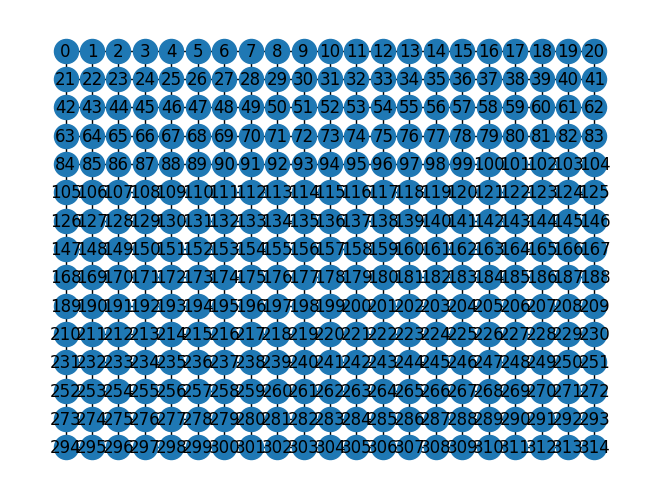

In [77]:
# create a 2D grid graph
k1 = 15
k2 = 21
grid = nx.grid_2d_graph(k1, k2)
n = k1 * k2
grid = nx.convert_node_labels_to_integers(grid)

# make grid undirected
# grid = grid.to_undirected()
# add edges in the opposite direction
# grid.add_edges_from([(v, u) for (u, v) in grid.edges()])

# plot the graph
# create 2D coordinates
pos = dict()
for i in range(k1):
    for j in range(k2):
        pos[i * k2 + j] = (j, -i)

nx.draw(grid, pos=pos, with_labels=True)

In [78]:
edges = list(grid.edges)
# add edges in the opposite direction
edge_index = torch.tensor(edges).t().contiguous()
x = torch.tensor(np.arange(n), dtype=torch.float)
A = nx.adjacency_matrix(grid).todense()
data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True)

True

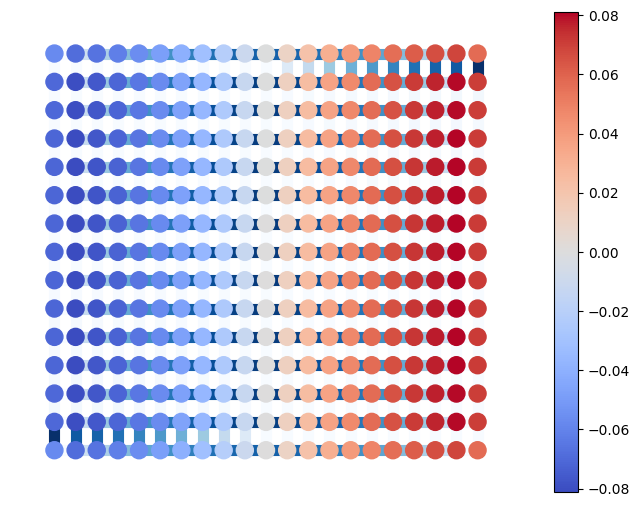

In [79]:
L = nx.normalized_laplacian_matrix(grid)
L = L.todense()
A = nx.adjacency_matrix(grid).todense()
eigenvalues, eigenvectors = np.linalg.eigh(L)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
intensity = fiedler_grad[edge_index[0], edge_index[1]]
# map to RGBA colors
edge_colors = plt.cm.Blues(normalize(intensity))
plot(grid, pos, fiedler_vector, edge_colors)

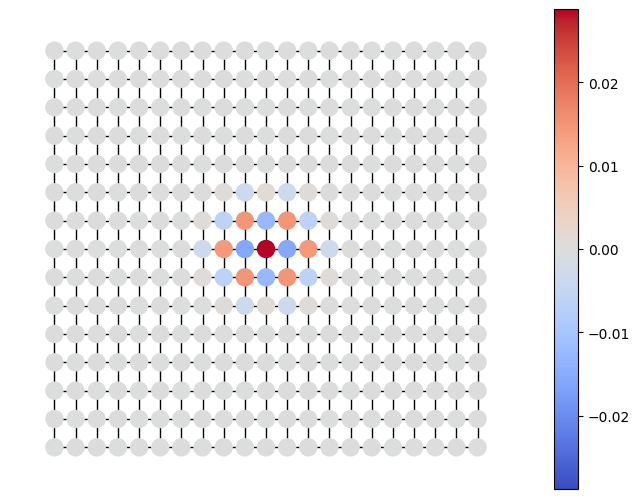

In [94]:
impulse = np.zeros(n)
impulse[n//2] = 1
# impulse[55] = 1
# impulse[109] = 1

g = lambda x, a0, a1, a2, a3, a4: a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4
filter_coefficients = g(eigenvalues, 1, 1, -1, -1, 0)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
fiedler_grad = np.abs(fiedler_grad)
# fiedler_grad_abs = np.abs(fiedler_grad)
# C = np.diag(filter_coefficients)
F = eigenvectors.T @ fiedler_grad @ eigenvectors
C = F @ np.diag(filter_coefficients)
# C = np.diag(filter_coefficients)
spectral_filter = eigenvectors @ C @ eigenvectors.T
output = spectral_filter @ impulse
# use the fiedler grad to modulate the output
# output = fiedler_grad @ output
plot(grid, pos, output)

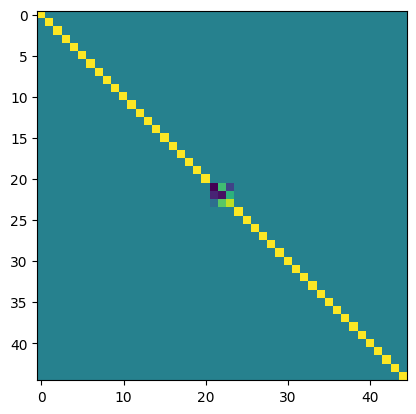

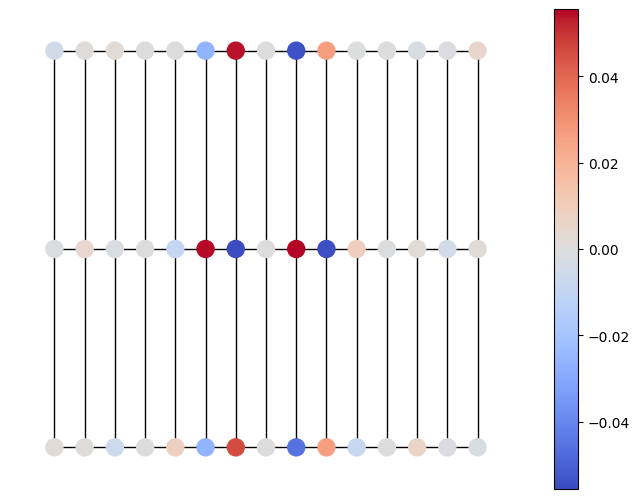

In [57]:
impulse = np.zeros(n)
impulse[n//2] = 1
# impulse[55] = 1
# impulse[109] = 1

Q, multiplicities = construct_block_diagonal_ortho(eigenvalues)

plt.imshow(Q)
plt.show()

g = lambda x, a0, a1, a2, a3, a4: a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4
filter_coefficients = g(eigenvalues, 1, 1, -1, -1, 0)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
# fiedler_grad_abs = np.abs(fiedler_grad)
# C = np.diag(filter_coefficients)
F = eigenvectors.T @ fiedler_grad @ eigenvectors
C = Q @ F @ np.diag(filter_coefficients) @ Q.T
# C = np.diag(filter_coefficients)
spectral_filter = eigenvectors @ C @ eigenvectors.T
output = spectral_filter @ impulse
# use the fiedler grad to modulate the output
# output = fiedler_grad @ output
plot(grid, pos, output)

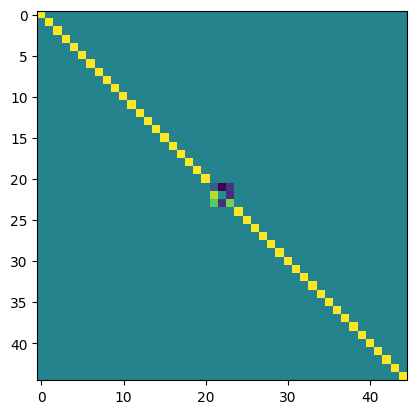

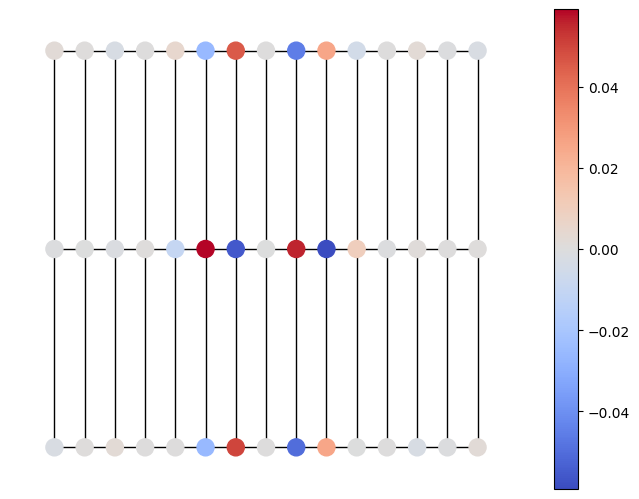

In [58]:
impulse = np.zeros(n)
impulse[n//2] = 1
# impulse[55] = 1
# impulse[109] = 1

Q, multiplicities = construct_block_diagonal_ortho(eigenvalues)

plt.imshow(Q)
plt.show()

g = lambda x, a0, a1, a2, a3, a4: a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4
filter_coefficients = g(eigenvalues, 1, 1, -1, -1, 0)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
# fiedler_grad_abs = np.abs(fiedler_grad)
# C = np.diag(filter_coefficients)
F = eigenvectors.T @ fiedler_grad @ eigenvectors
C = Q @ F @ np.diag(filter_coefficients) @ Q.T
# C = np.diag(filter_coefficients)
spectral_filter = eigenvectors @ C @ eigenvectors.T
output = spectral_filter @ impulse
# use the fiedler grad to modulate the output
# output = fiedler_grad @ output
plot(grid, pos, output)

In [60]:
# load zinc dataset
from torch_geometric.datasets import zinc
dataset = zinc.ZINC('./data/ZINC', subset=True)

C:\Users\guyle\OneDrive\Documents\math_gnn_project\env\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


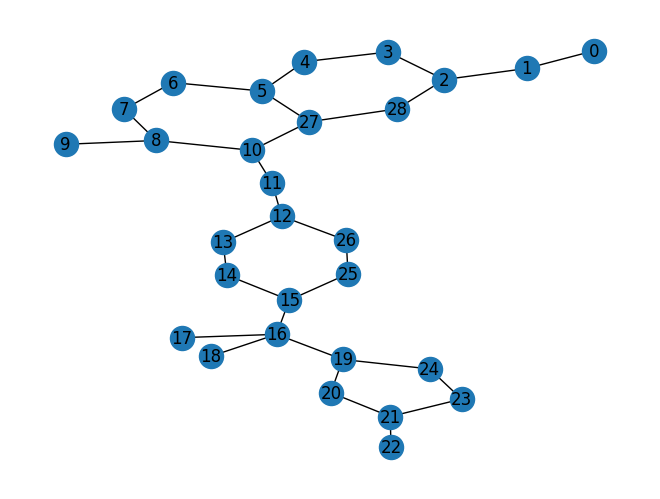

In [61]:
data = dataset[0]
data.validate(raise_on_error=True)
dataloaders = DataLoader(dataset, batch_size=1, shuffle=False)
sample = next(iter(dataloaders))[0]
G = nx.Graph()
edge_index = sample.edge_index
G.add_edges_from(edge_index.t().tolist())
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True)

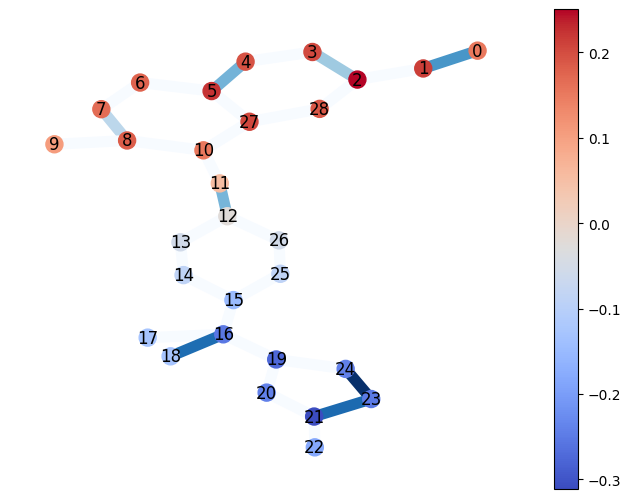

In [62]:
L = nx.normalized_laplacian_matrix(G)
L = L.todense()
A = nx.adjacency_matrix(G).todense()
eigenvalues, eigenvectors = np.linalg.eigh(L)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
intensity = fiedler_grad[edge_index[0], edge_index[1]]
# map to RGBA colors
edge_colors = plt.cm.Blues(normalize(intensity))
plot(G, pos, fiedler_vector, edge_colors, with_labels=True)

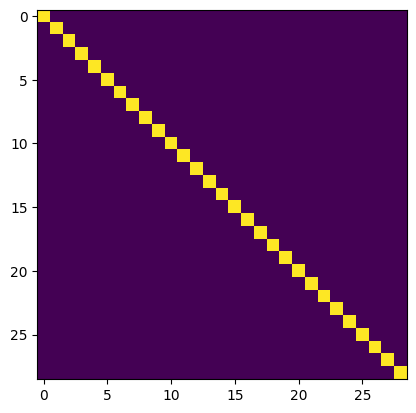

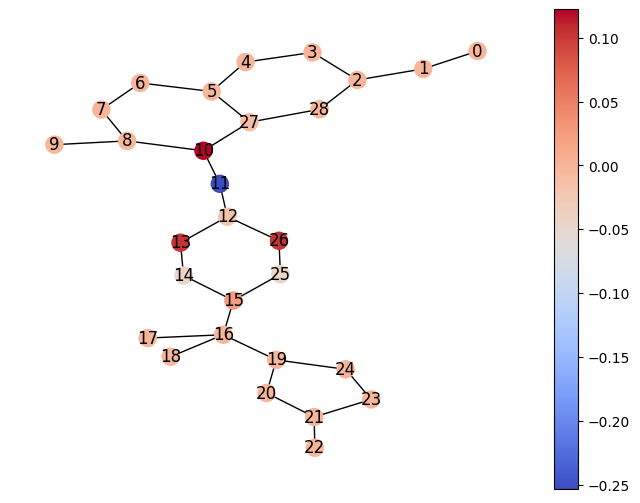

In [73]:
n = len(eigenvalues)
impulse = np.zeros(n)
impulse[n//2] = 1
# impulse[21] = 1
# impulse[16] = 1
# impulse[21] = 1

Q, multiplicities = construct_block_diagonal_ortho(eigenvalues)
plt.imshow(Q)
plt.show()

g = lambda x, a0, a1, a2, a3, a4: a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4
filter_coefficients = g(eigenvalues, 1, 1, 1, 0, 0)
fiedler_vector = eigenvectors[:, 1]
# fiedler_vector[fiedler_vector < 1e-10] = 0
fiedler_grad = edge_gradient(A, fiedler_vector)
# C = np.diag(filter_coefficients)
F = eigenvectors.T @ fiedler_grad @ eigenvectors
C = F @ np.diag(filter_coefficients)

spectral_filter = eigenvectors @ C @ eigenvectors.T
output = spectral_filter @ impulse

# output = fiedler_grad @ output
plot(G, pos, output, with_labels=True)